In [1]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from functools import reduce
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import maxabs_scale, minmax_scale, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Abrindo datasets

In [2]:
files = list(filter(lambda x: x.endswith('pkl'), os.listdir()))
#features = ['sobel', 'glcm', 'lbp', 'img']
features = ['glcm', 'lbp', 'img']
datasets = {}

In [3]:
for file in files:
    datasets[file.split('.')[0]] = pd.read_pickle(file)

for dataset in datasets.keys():
    datasets[dataset] = datasets[dataset].sort_values('label')
    datasets[dataset]['img'] = [x.reshape(-1) for x in datasets[dataset]['img']]
    #datasets[dataset]['glcm'] = [minmax_scale(x, feature_range=(0,1), axis=0) for x in datasets[dataset]['glcm']]
    #datasets[dataset]['img'] = [minmax_scale(x, feature_range=(0,1), axis=0) for x in datasets[dataset]['img']]
    #datasets[dataset]['lbp'] = [minmax_scale(x, feature_range=(0,1), axis=0) for x in datasets[dataset]['lbp']]

In [4]:
selected = ['gaussian', 'equalize_hist', 'gamma_correction2', 'original']

### StratifiedKFold para dividir os conjuntos de treino / teste  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [5]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

## Unindo as features

In [6]:
#X, y = np.column_stack([datasets[x][y].tolist() for x in datasets.keys() for y in features]), datasets['gaussian']['class']
#X, y = np.array(np.column_stack([np.array(datasets[y]['img'][x]).reshape(-1) for x in range(811)] for y in datasets.keys())), datasets['equalize_hist']['class']
#X, y = np.column_stack([np.array(datasets[y]['img']) for y in datasets.keys()]), datasets['equalize_hist']['class']

In [7]:
#w = np.column_stack([np.array([datasets[y]['img'][x].tolist() for x in range(811)]) for y in selected])
#w = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
#w = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
#w = pd.concat([datasets[y][['img']] for y in selected], axis=1)

# apenas lbp

In [52]:
w = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [53]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 68) (811,)


In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## SVM

In [11]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [12]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [13]:
grid_svm.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.001, 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [14]:
grid_svm.best_estimator_

SVC(C=1, random_state=42)

In [59]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=1, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print() 
    lbp_ans = svm.predict_proba(X_test)

lbp_svm_ans = lbp_ans
#print(classification_report(y_test, lbp_svm_ans))

0
              precision    recall  f1-score   support

           0       0.78      0.52      0.62       155
           1       0.75      0.91      0.82       251

    accuracy                           0.76       406
   macro avg       0.76      0.71      0.72       406
weighted avg       0.76      0.76      0.75       406


1
              precision    recall  f1-score   support

           0       0.73      0.46      0.57       145
           1       0.75      0.90      0.82       260

    accuracy                           0.75       405
   macro avg       0.74      0.68      0.69       405
weighted avg       0.74      0.75      0.73       405




## MLP

In [16]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.01], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [13]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

NameError: name 'mlp_grid' is not defined

In [18]:
grid_mlp.fit(X, y)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     n_iter_no_change=80, random_state=42,
                                     warm_start=True),
             n_jobs=8,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [64, 128],
                         'learning_rate': ['constant', 'adaptative'],
                         'learning_rate_init': [0.001, 0.0005],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [19]:
grid_mlp.best_estimator_

MLPClassifier(early_stopping=True, hidden_layer_sizes=128, max_iter=500,
              n_iter_no_change=80, random_state=42, warm_start=True)

In [61]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    #mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,learning_rate_init=0.0005,warm_start=True,early_stopping=True,max_iter=500, activation='relu', n_iter_no_change=80, alpha=0.001)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,warm_start=True,early_stopping=True,max_iter=500, n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_mlp_ans = mlp.predict_proba(X_test)

lbp_mlp_ans = lbp_mlp_ans
#print(classification_report(y_test, lbp_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       155
           1       0.76      0.84      0.80       251

    accuracy                           0.74       406
   macro avg       0.72      0.70      0.71       406
weighted avg       0.73      0.74      0.73       406


1
              precision    recall  f1-score   support

           0       0.48      0.47      0.47       145
           1       0.71      0.71      0.71       260

    accuracy                           0.62       405
   macro avg       0.59      0.59      0.59       405
weighted avg       0.62      0.62      0.62       405




# apenas glcm

In [63]:
w = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [64]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 400) (811,)


In [65]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## SVM

In [24]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [25]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [26]:
grid_svm.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.001, 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [27]:
grid_svm.best_estimator_

SVC(C=1, random_state=42)

In [67]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=1, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    glcm_svm_ans = svm.predict_proba(X_test)

glcm_svm_ans = glcm_svm_ans
#print(classification_report(y_test, glcm_svm_ans))

0
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       155
           1       0.85      0.94      0.89       251

    accuracy                           0.86       406
   macro avg       0.87      0.84      0.85       406
weighted avg       0.86      0.86      0.86       406


1
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       145
           1       0.87      0.94      0.90       260

    accuracy                           0.87       405
   macro avg       0.87      0.85      0.86       405
weighted avg       0.87      0.87      0.87       405




## MLP

In [29]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.05], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [30]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [31]:
grid_mlp.fit(X, y)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     n_iter_no_change=80, random_state=42,
                                     warm_start=True),
             n_jobs=8,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.05],
                         'hidden_layer_sizes': [64, 128],
                         'learning_rate': ['constant', 'adaptative'],
                         'learning_rate_init': [0.001, 0.0005],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [32]:
grid_mlp.best_estimator_

MLPClassifier(early_stopping=True, hidden_layer_sizes=128,
              learning_rate_init=0.0005, max_iter=500, n_iter_no_change=80,
              random_state=42, warm_start=True)

In [68]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,learning_rate_init=0.0005,warm_start=True,early_stopping=True,max_iter=500, n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    glcm_mlp_ans = mlp.predict_proba(X_test)

glcm_mlp_ans = glcm_mlp_ans
#print(classification_report(y_test, glcm_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       155
           1       0.86      0.88      0.87       251

    accuracy                           0.83       406
   macro avg       0.83      0.82      0.82       406
weighted avg       0.83      0.83      0.83       406


1
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       145
           1       0.89      0.85      0.87       260

    accuracy                           0.84       405
   macro avg       0.82      0.83      0.83       405
weighted avg       0.84      0.84      0.84       405




# apenas img

In [69]:
w = np.column_stack([np.array([datasets[y]['img'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [70]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 90000) (811,)


In [71]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## SVM

In [ ]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.01,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [ ]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_svm.fit(X, y)

In [ ]:
grid_svm.best_estimator_

In [72]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=1, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    img_svm_ans = svm.predict_proba(X_test)

img_svm_ans = img_svm_ans
#print(classification_report(y_test, img_svm_ans))

0
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       155
           1       0.85      0.92      0.88       251

    accuracy                           0.84       406
   macro avg       0.84      0.82      0.83       406
weighted avg       0.84      0.84      0.84       406


1
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       145
           1       0.84      0.91      0.87       260

    accuracy                           0.83       405
   macro avg       0.82      0.80      0.81       405
weighted avg       0.83      0.83      0.83       405




## MLP

In [ ]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.05], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [ ]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_mlp.fit(X, y)

In [ ]:
grid_mlp.best_estimator_

In [74]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,learning_rate_init=0.0005,warm_start=True,early_stopping=True,max_iter=500,n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    img_mlp_ans = mlp.predict_proba(X_test)

img_mlp_ans = img_mlp_ans
#print(classification_report(y_test, img_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       155
           1       0.87      0.84      0.85       251

    accuracy                           0.82       406
   macro avg       0.81      0.82      0.81       406
weighted avg       0.82      0.82      0.82       406


1
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       145
           1       0.90      0.85      0.87       260

    accuracy                           0.84       405
   macro avg       0.83      0.84      0.83       405
weighted avg       0.85      0.84      0.84       405




# lbp + glcm

In [76]:
w1 = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
w2 = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [77]:
scaler = StandardScaler()
w1 = scaler.fit_transform(w1)
w2 = scaler.fit_transform(w2)

In [78]:
w = np.concatenate([w1,w2],axis=1)

In [79]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 468) (811,)


## SVM

In [161]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [162]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [163]:
grid_svm.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.001, 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [164]:
grid_svm.best_estimator_

SVC(C=1, random_state=42)

In [80]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=10, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_glcm_svm_ans = svm.predict_proba(X_test)

lbp_glcm_svm_ans = lbp_glcm_svm_ans
#print(classification_report(y_test, lbp_glcm_svm_ans))

0
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       155
           1       0.89      0.96      0.92       251

    accuracy                           0.90       406
   macro avg       0.91      0.88      0.89       406
weighted avg       0.90      0.90      0.90       406


1
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       145
           1       0.88      0.92      0.90       260

    accuracy                           0.87       405
   macro avg       0.86      0.85      0.86       405
weighted avg       0.87      0.87      0.87       405




## MLP

In [166]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.01], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [167]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [168]:
grid_mlp.fit(X, y)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     n_iter_no_change=80, random_state=42,
                                     warm_start=True),
             n_jobs=8,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [64, 128],
                         'learning_rate': ['constant', 'adaptative'],
                         'learning_rate_init': [0.001, 0.0005],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [169]:
grid_mlp.best_estimator_

MLPClassifier(early_stopping=True, hidden_layer_sizes=128,
              learning_rate_init=0.0005, max_iter=500, n_iter_no_change=80,
              random_state=42, warm_start=True)

In [81]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,warm_start=True,learning_rate_init=0.0005,early_stopping=True,max_iter=500,n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_glcm_mlp_ans = mlp.predict_proba(X_test)

lbp_glcm_mlp_ans = lbp_glcm_mlp_ans
#print(classification_report(y_test, lbp_glcm_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       155
           1       0.86      0.72      0.78       251

    accuracy                           0.75       406
   macro avg       0.75      0.77      0.75       406
weighted avg       0.78      0.75      0.76       406


1
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       145
           1       0.89      0.86      0.87       260

    accuracy                           0.84       405
   macro avg       0.83      0.84      0.83       405
weighted avg       0.85      0.84      0.84       405




# lbp + img

In [83]:
w1 = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
w2 = np.column_stack([np.array([datasets[y]['img'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [84]:
scaler = StandardScaler()
w1 = scaler.fit_transform(w1)
w2 = scaler.fit_transform(w2)

In [85]:
w = np.concatenate([w1,w2],axis=1)

In [86]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 90068) (811,)


## SVM

In [ ]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.01,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [ ]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_svm.fit(X, y)

In [ ]:
grid_svm.best_estimator_

In [87]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=1, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_img_svm_ans = svm.predict_proba(X_test)

lbp_img_svm_ans = lbp_img_svm_ans
#print(classification_report(y_test, lbp_img_svm_ans))

0
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       155
           1       0.85      0.92      0.88       251

    accuracy                           0.84       406
   macro avg       0.84      0.82      0.83       406
weighted avg       0.84      0.84      0.84       406


1
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       145
           1       0.84      0.91      0.87       260

    accuracy                           0.83       405
   macro avg       0.82      0.80      0.81       405
weighted avg       0.83      0.83      0.83       405




## MLP

In [ ]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.05], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [ ]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_mlp.fit(X, y)

In [ ]:
grid_mlp.best_estimator_

In [88]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,warm_start=True,early_stopping=True,max_iter=500,n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_img_mlp_ans = mlp.predict_proba(X_test)

lbp_img_mlp_ans = lbp_img_mlp_ans
#print(classification_report(y_test, lbp_img_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       155
           1       0.82      0.84      0.83       251

    accuracy                           0.79       406
   macro avg       0.77      0.77      0.77       406
weighted avg       0.78      0.79      0.78       406


1
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       145
           1       0.88      0.84      0.86       260

    accuracy                           0.83       405
   macro avg       0.81      0.82      0.82       405
weighted avg       0.83      0.83      0.83       405




# glcm + img

In [89]:
w1 = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
w2 = np.column_stack([np.array([datasets[y]['img'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [90]:
scaler = StandardScaler()
w1 = scaler.fit_transform(w1)
w2 = scaler.fit_transform(w2)

In [91]:
w = np.concatenate([w1,w2],axis=1)

In [92]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 90400) (811,)


## SVM

In [ ]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.01,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [ ]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_svm.fit(X, y)

In [ ]:
grid_svm.best_estimator_

In [94]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=10, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    glcm_img_svm_ans = svm.predict_proba(X_test)

glcm_img_svm_ans = glcm_img_svm_ans
#print(classification_report(y_test, glcm_img_svm_ans))

0
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       155
           1       0.86      0.91      0.88       251

    accuracy                           0.85       406
   macro avg       0.85      0.83      0.84       406
weighted avg       0.85      0.85      0.85       406


1
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       145
           1       0.86      0.92      0.89       260

    accuracy                           0.85       405
   macro avg       0.85      0.82      0.83       405
weighted avg       0.85      0.85      0.85       405




## MLP

In [ ]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.05], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [ ]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_mlp.fit(X, y)

In [ ]:
grid_mlp.best_estimator_

In [95]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,learning_rate_init=0.0005,warm_start=True,early_stopping=True,max_iter=500, n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    glcm_img_mlp_ans = mlp.predict_proba(X_test)

glcm_img_mlp_ans = glcm_img_mlp_ans
#print(classification_report(y_test, glcm_img_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       155
           1       0.85      0.72      0.78       251

    accuracy                           0.75       406
   macro avg       0.74      0.76      0.74       406
weighted avg       0.77      0.75      0.75       406


1
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       145
           1       0.88      0.83      0.86       260

    accuracy                           0.82       405
   macro avg       0.80      0.82      0.81       405
weighted avg       0.83      0.82      0.82       405




# lbp + glcm + img

In [96]:
w1 = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
w2 = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
w3 = np.column_stack([np.array([datasets[y]['img'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [97]:
scaler = StandardScaler()
w1 = scaler.fit_transform(w1)
w2 = scaler.fit_transform(w2)
w3 = scaler.fit_transform(w3)

In [98]:
w = np.concatenate([w1,w2,w3],axis=1)

In [99]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 90468) (811,)


## SVM

In [ ]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.01,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [ ]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_svm.fit(X, y)

In [ ]:
grid_svm.best_estimator_

In [101]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=10, probability=True)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_glcm_img_svm_ans = svm.predict_proba(X_test)

lbp_glcm_img_svm_ans = lbp_glcm_img_svm_ans
#print(classification_report(y_test, lbp_glcm_img_svm_ans))

0
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       155
           1       0.86      0.91      0.88       251

    accuracy                           0.85       406
   macro avg       0.85      0.83      0.84       406
weighted avg       0.85      0.85      0.85       406


1
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       145
           1       0.86      0.92      0.89       260

    accuracy                           0.85       405
   macro avg       0.85      0.82      0.83       405
weighted avg       0.85      0.85      0.85       405




## MLP

In [ ]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.05], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [ ]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [ ]:
grid_mlp.fit(X, y)

In [ ]:
grid_mlp.best_estimator_

In [102]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,warm_start=True,early_stopping=True,max_iter=500, n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()
    lbp_glcm_img_mlp_ans = mlp.predict_proba(X_test)

lbp_glcm_img_mlp_ans = lbp_glcm_img_mlp_ans
#print(classification_report(y_test, lbp_glcm_img_mlp_ans))

0
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       155
           1       0.86      0.86      0.86       251

    accuracy                           0.83       406
   macro avg       0.82      0.82      0.82       406
weighted avg       0.83      0.83      0.83       406


1
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       145
           1       0.90      0.87      0.89       260

    accuracy                           0.86       405
   macro avg       0.84      0.85      0.85       405
weighted avg       0.86      0.86      0.86       405




# ROC, AUC and PR Curves

## ROC, AUC and PR - SVM

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

In [112]:
x_lbp_svm, y_lbp_svm, _ = roc_curve(y_test, lbp_svm_ans[:,1])
x_glcm_svm, y_glcm_svm, _ = roc_curve(y_test, glcm_svm_ans[:,1])
x_img_svm, y_img_svm, _ = roc_curve(y_test, img_svm_ans[:,1])
x_lbp_glcm_svm, y_lbp_glcm_svm, _ = roc_curve(y_test, lbp_glcm_svm_ans[:,1])
x_lbp_img_svm, y_lbp_img_svm, _ = roc_curve(y_test, lbp_img_svm_ans[:,1])
x_glcm_img_svm, y_glcm_img_svm, _ = roc_curve(y_test, glcm_img_svm_ans[:,1])
x_lbp_glcm_img_svm, y_lbp_glcm_img_svm, _ = roc_curve(y_test, lbp_glcm_img_svm_ans[:,1])

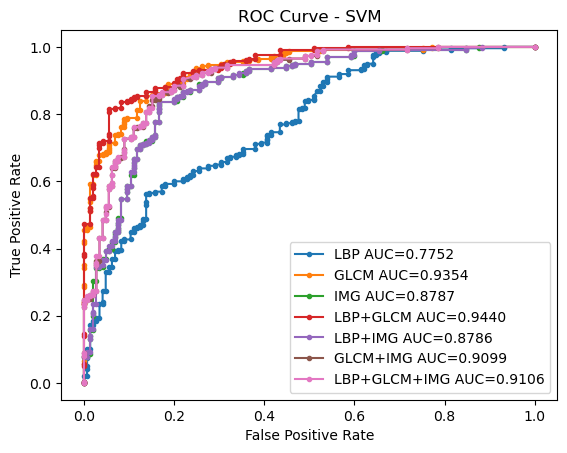

In [124]:
plt.plot(x_lbp_svm, y_lbp_svm, marker='.', label=f'LBP AUC={auc(x_lbp_svm,y_lbp_svm):.4f}')
plt.plot(x_glcm_svm, y_glcm_svm, marker='.', label=f'GLCM AUC={auc(x_glcm_svm, y_glcm_svm):.4f}')
plt.plot(x_img_svm, y_img_svm, marker='.', label=f'IMG AUC={auc(x_img_svm, y_img_svm):.4f}')
plt.plot(x_lbp_glcm_svm, y_lbp_glcm_svm, marker='.', label=f'LBP+GLCM AUC={auc(x_lbp_glcm_svm, y_lbp_glcm_svm):.4f}')
plt.plot(x_lbp_img_svm, y_lbp_img_svm, marker='.', label=f'LBP+IMG AUC={auc(x_lbp_img_svm, y_lbp_img_svm):.4f}')
plt.plot(x_glcm_img_svm, y_glcm_img_svm, marker='.', label=f'GLCM+IMG AUC={auc(x_glcm_img_svm, y_glcm_img_svm):.4f}')
plt.plot(x_lbp_glcm_img_svm, y_lbp_glcm_img_svm, marker='.', label=f'LBP+GLCM+IMG AUC={auc(x_lbp_glcm_img_svm, y_lbp_glcm_img_svm):.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()

In [140]:
x_lbp_svm, y_lbp_svm, _ = precision_recall_curve(y_test, lbp_svm_ans[:,1])
x_glcm_svm, y_glcm_svm, _ = precision_recall_curve(y_test, glcm_svm_ans[:,1])
x_img_svm, y_img_svm, _ = precision_recall_curve(y_test, img_svm_ans[:,1])
x_lbp_glcm_svm, y_lbp_glcm_svm, _ = precision_recall_curve(y_test, lbp_glcm_svm_ans[:,1])
x_lbp_img_svm, y_lbp_img_svm, _ = precision_recall_curve(y_test, lbp_img_svm_ans[:,1])
x_glcm_img_svm, y_glcm_img_svm, _ = precision_recall_curve(y_test, glcm_img_svm_ans[:,1])
x_lbp_glcm_img_svm, y_lbp_glcm_img_svm, _ = precision_recall_curve(y_test, lbp_glcm_img_svm_ans[:,1])

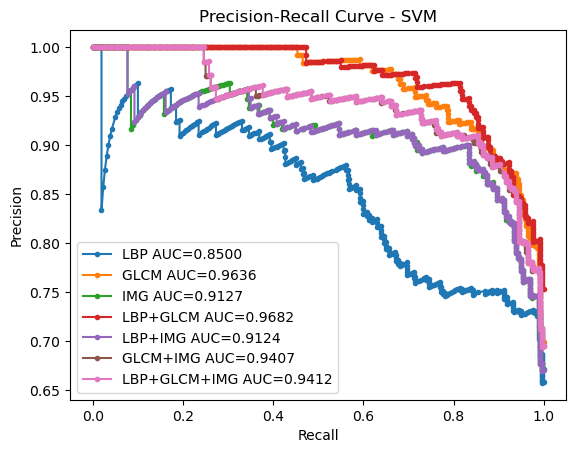

In [145]:
plt.plot(y_lbp_svm, x_lbp_svm, marker='.', label=f'LBP AUC={auc(y_lbp_svm, x_lbp_svm):.4f}')
plt.plot(y_glcm_svm, x_glcm_svm, marker='.', label=f'GLCM AUC={auc(y_glcm_svm, x_glcm_svm):.4f}')
plt.plot(y_img_svm, x_img_svm, marker='.', label=f'IMG AUC={auc(y_img_svm, x_img_svm):.4f}')
plt.plot(y_lbp_glcm_svm, x_lbp_glcm_svm, marker='.', label=f'LBP+GLCM AUC={auc(y_lbp_glcm_svm, x_lbp_glcm_svm):.4f}')
plt.plot(y_lbp_img_svm, x_lbp_img_svm, marker='.', label=f'LBP+IMG AUC={auc(y_lbp_img_svm, x_lbp_img_svm):.4f}')
plt.plot(y_glcm_img_svm, x_glcm_img_svm, marker='.', label=f'GLCM+IMG AUC={auc(y_glcm_img_svm, x_glcm_img_svm):.4f}')
plt.plot(y_lbp_glcm_img_svm, x_lbp_glcm_img_svm, marker='.', label=f'LBP+GLCM+IMG AUC={auc(y_lbp_glcm_img_svm, x_lbp_glcm_img_svm):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM')
plt.legend()
plt.show()

## ROC, AUC and PR - MLP

In [125]:
x_lbp_mlp, y_lbp_mlp, _ = roc_curve(y_test, lbp_mlp_ans[:,1])
x_glcm_mlp, y_glcm_mlp, _ = roc_curve(y_test, glcm_mlp_ans[:,1])
x_img_mlp, y_img_mlp, _ = roc_curve(y_test, img_mlp_ans[:,1])
x_lbp_glcm_mlp, y_lbp_glcm_mlp, _ = roc_curve(y_test, lbp_glcm_mlp_ans[:,1])
x_lbp_img_mlp, y_lbp_img_mlp, _ = roc_curve(y_test, lbp_img_mlp_ans[:,1])
x_glcm_img_mlp, y_glcm_img_mlp, _ = roc_curve(y_test, glcm_img_mlp_ans[:,1])
x_lbp_glcm_img_mlp, y_lbp_glcm_img_mlp, _ = roc_curve(y_test, lbp_glcm_img_mlp_ans[:,1])

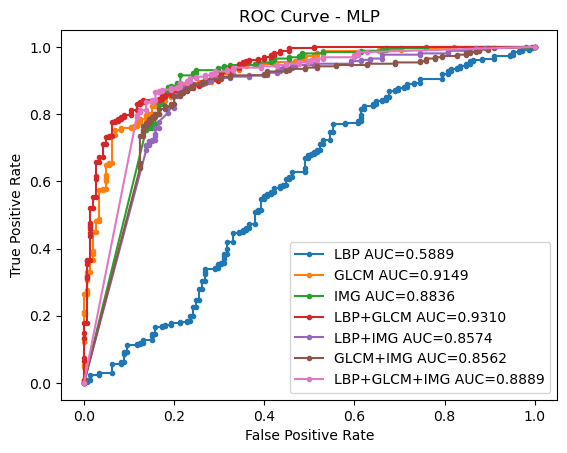

In [128]:
plt.plot(x_lbp_mlp, y_lbp_mlp, marker='.', label=f'LBP AUC={auc(x_lbp_mlp,y_lbp_mlp):.4f}')
plt.plot(x_glcm_mlp, y_glcm_mlp, marker='.', label=f'GLCM AUC={auc(x_glcm_mlp, y_glcm_mlp):.4f}')
plt.plot(x_img_mlp, y_img_mlp, marker='.', label=f'IMG AUC={auc(x_img_mlp, y_img_mlp):.4f}')
plt.plot(x_lbp_glcm_mlp, y_lbp_glcm_mlp, marker='.', label=f'LBP+GLCM AUC={auc(x_lbp_glcm_mlp, y_lbp_glcm_mlp):.4f}')
plt.plot(x_lbp_img_mlp, y_lbp_img_mlp, marker='.', label=f'LBP+IMG AUC={auc(x_lbp_img_mlp, y_lbp_img_mlp):.4f}')
plt.plot(x_glcm_img_mlp, y_glcm_img_mlp, marker='.', label=f'GLCM+IMG AUC={auc(x_glcm_img_mlp, y_glcm_img_mlp):.4f}')
plt.plot(x_lbp_glcm_img_mlp, y_lbp_glcm_img_mlp, marker='.', label=f'LBP+GLCM+IMG AUC={auc(x_lbp_glcm_img_mlp, y_lbp_glcm_img_mlp):.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend()
plt.show()

In [142]:
x_lbp_mlp, y_lbp_mlp, _ = precision_recall_curve(y_test, lbp_mlp_ans[:,1])
x_glcm_mlp, y_glcm_mlp, _ = precision_recall_curve(y_test, glcm_mlp_ans[:,1])
x_img_mlp, y_img_mlp, _ = precision_recall_curve(y_test, img_mlp_ans[:,1])
x_lbp_glcm_mlp, y_lbp_glcm_mlp, _ = precision_recall_curve(y_test, lbp_glcm_mlp_ans[:,1])
x_lbp_img_mlp, y_lbp_img_mlp, _ = precision_recall_curve(y_test, lbp_img_mlp_ans[:,1])
x_glcm_img_mlp, y_glcm_img_mlp, _ = precision_recall_curve(y_test, glcm_img_mlp_ans[:,1])
x_lbp_glcm_img_mlp, y_lbp_glcm_img_mlp, _ = precision_recall_curve(y_test, lbp_glcm_img_mlp_ans[:,1])

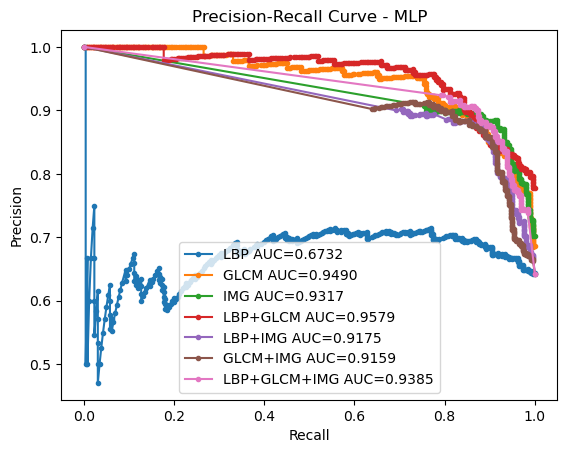

In [146]:
plt.plot(y_lbp_mlp, x_lbp_mlp, marker='.', label=f'LBP AUC={auc(y_lbp_mlp, x_lbp_mlp):.4f}')
plt.plot(y_glcm_mlp, x_glcm_mlp, marker='.', label=f'GLCM AUC={auc(y_glcm_mlp, x_glcm_mlp):.4f}')
plt.plot(y_img_mlp, x_img_mlp, marker='.', label=f'IMG AUC={auc(y_img_mlp, x_img_mlp):.4f}')
plt.plot(y_lbp_glcm_mlp, x_lbp_glcm_mlp, marker='.', label=f'LBP+GLCM AUC={auc(y_lbp_glcm_mlp, x_lbp_glcm_mlp):.4f}')
plt.plot(y_lbp_img_mlp, x_lbp_img_mlp, marker='.', label=f'LBP+IMG AUC={auc(y_lbp_img_mlp, x_lbp_img_mlp):.4f}')
plt.plot(y_glcm_img_mlp, x_glcm_img_mlp, marker='.', label=f'GLCM+IMG AUC={auc(y_glcm_img_mlp, x_glcm_img_mlp):.4f}')
plt.plot(y_lbp_glcm_img_mlp, x_lbp_glcm_img_mlp, marker='.', label=f'LBP+GLCM+IMG AUC={auc(y_lbp_glcm_img_mlp, x_lbp_glcm_img_mlp):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MLP')
plt.legend()
plt.show()

# lbp + glcm -> improving

In [148]:
selected = ['gaussian', 'equalize_hist', 'gamma_correction3', 'original']

In [149]:
scaler = StandardScaler()

In [150]:
w1 = np.column_stack([np.array([datasets[y]['glcm'][x].tolist() for x in range(811)]) for y in selected])
w2 = np.column_stack([np.array([datasets[y]['lbp'][x].tolist() for x in range(811)]) for y in selected])
y = datasets['gaussian']['class']

In [152]:
w1 = scaler.fit_transform(w1)
w2 = scaler.fit_transform(w2)

In [153]:
w = np.concatenate([w1,w2],axis=1)

In [154]:
X = w
print(X.shape, y.shape)
X = X.astype('float32')

(811, 800) (811,)


## SVM

In [136]:
svm_grid = {\
    'C': [0.1, 1, 10, 100], 'gamma': [1,0.001,'scale'], 'kernel': ['linear', 'rbf', 'poly'] \
}

In [137]:
grid_svm = GridSearchCV(SVC(random_state=42), param_grid=svm_grid, verbose=2, n_jobs=8, cv=skf)

In [138]:
grid_svm.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.001, 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [139]:
grid_svm.best_estimator_

SVC(C=1, random_state=42)

In [155]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    svm = SVC(random_state=42, kernel='rbf', C=10)
    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()  

0
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       155
           1       0.89      0.95      0.92       251

    accuracy                           0.89       406
   macro avg       0.90      0.88      0.89       406
weighted avg       0.89      0.89      0.89       406


1
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       145
           1       0.86      0.92      0.89       260

    accuracy                           0.85       405
   macro avg       0.85      0.83      0.83       405
weighted avg       0.85      0.85      0.85       405




## MLP

In [142]:
mlp_grid = {\
    'hidden_layer_sizes': [64, 128], 'learning_rate_init': [0.001, 0.0005], 'alpha': [0.0001, 0.001, 0.01], \
    'activation': ['identity', 'tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptative']\
}

In [143]:
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=80, max_iter=500), param_grid=mlp_grid, verbose=2, n_jobs=8, cv=skf)

In [144]:
grid_mlp.fit(X, y)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     n_iter_no_change=80, random_state=42,
                                     warm_start=True),
             n_jobs=8,
             param_grid={'activation': ['identity', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [64, 128],
                         'learning_rate': ['constant', 'adaptative'],
                         'learning_rate_init': [0.001, 0.0005],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [145]:
grid_mlp.best_estimator_

MLPClassifier(early_stopping=True, hidden_layer_sizes=128,
              learning_rate_init=0.0005, max_iter=500, n_iter_no_change=80,
              random_state=42, warm_start=True)

In [156]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(i)
    mlp = MLPClassifier(random_state=42,hidden_layer_sizes=128,learning_rate_init=0.0005,warm_start=True,early_stopping=True,max_iter=500,n_iter_no_change=80)

    mlp.fit(X_train, y_train)
    y_hat = mlp.predict(X_test)
    print(classification_report(y_test, y_hat))
    print()

0
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       155
           1       0.90      0.92      0.91       251

    accuracy                           0.88       406
   macro avg       0.88      0.87      0.88       406
weighted avg       0.88      0.88      0.88       406


1
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       145
           1       0.89      0.88      0.88       260

    accuracy                           0.85       405
   macro avg       0.84      0.84      0.84       405
weighted avg       0.85      0.85      0.85       405


